### Importing Libraries

This section imports all the essential libraries for data analysis, visualization, preprocessing, and model training. Additionally, setting a fixed random seed (SEED) ensures reproducibility of results, and configuring TensorFlow’s threading options guarantees deterministic execution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tkinter as tk
from tkinter import messagebox

import keras
from keras import layers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


import random
import os

SEED = 12345

random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

### Loading the Dataset
The dataset is loaded from a CSV file named data.csv using pandas. The semicolon is specified as the separator since the file uses “;” instead of a comma to separate values.

In [2]:
df = pd.read_csv("data.csv", sep=";")

In [3]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Data preprocessing
In this section, the dataset is prepared and cleaned for model training. All data undergo the same preprocessing steps to ensure consistency. GPT was used only to suggest possible mapping strategies for creating new columns, and only the descriptions of the data values (e.g., what the numbers like 1, 2, or 3 represent) were provided so that meaningful columns could be created. No actual data was shared with the AI. The reference code for the data mapping logic was adapted from the following source: https://stackoverflow.com/questions/19913659/how-do-i-create-a-new-column-where-the-values-are-selected-based-on-an-existing

The Marital status column is converted into three new binary columns, single, partnered, and previously_partnered, to simplify categorical data. The original column is then removed.

In [4]:
df["single"] = (df["Marital status"] == 1).astype(int)
df["partnered"] = df["Marital status"].isin([2, 5]).astype(int)
df["prev_partnered"] = df["Marital status"].isin([3, 4, 6]).astype(int)
df = df.drop(columns=["Marital status"])

The Application mode column is mapped into three new binary columns, admission_general, admission_transfer, and admission_special/international. to group different admission types into broader categories. The original column is then removed.

In [5]:
df["admission_general"] = df["Application mode"].isin([1, 17, 18]).astype(int)
df["admission_transfer"] = df["Application mode"].isin([42, 43, 44, 51, 53, 57]).astype(int)
df["admission_special/international"] = df["Application mode"].isin([2, 5, 7, 10, 15, 16, 26, 27, 39]).astype(int)
df = df.drop(columns=["Application mode"])

The Application order column is transformed into a binary column called high_priority, indicating whether the application was among the top three choices. The original column is then removed.

In [6]:
df["high_priority"] = (df["Application order"] <= 3).astype(int)
df = df.drop(columns=["Application order"])

The Course column is mapped into three new binary columns, studyfield_stem, studyfield_business_social, and studyfield_arts&comm, to group study programs into broader academic categories. The original column is then removed.

In [7]:
df["studyfield_stem"] = df["Course"].isin([33, 9119, 9085]).astype(int)
df["studyfield_business_social"] = df["Course"].isin([9147, 9991, 9670, 9254, 8014, 9238, 9853]).astype(int)
df["studyfield_arts&comm"] = df["Course"].isin([171, 9070, 9773, 9130, 9500, 9556]).astype(int)
df = df.drop(columns=["Course"])

The Daytime/evening attendance column is renamed to is_daytime to simplify interpretation of study attendance type. The original column is then removed.

In [8]:
df["is_daytime"] = df["Daytime/evening attendance\t"]
df = df.drop(columns=["Daytime/evening attendance\t"])

The Previous qualification column is mapped into three new binary columns, prevqual_basic, prevqual_secondary, and prevqual_higher, to categorize students by their highest level of prior education. The original column is then removed.

In [9]:
df["prevqual_basic"] = df["Previous qualification"].isin([9, 10, 12, 14, 15, 19, 38]).astype(int)
df["prevqual_secondary"] = df["Previous qualification"].isin([1, 39]).astype(int)
df["prevqual_higher"] = df["Previous qualification"].isin([2, 3, 4, 5, 6, 40, 42, 43]).astype(int)
df = df.drop(columns=["Previous qualification"])

The Nationality column is mapped into five new binary columns, nationality_europe, nationality_africa, nationality_south_america, nationality_north_america, and nationality_asia, to group students by their continent of origin. The original column is then removed.

In [10]:
df["nationality_europe"] = df["Nacionality"].isin([1, 2, 6, 11, 13, 14, 17, 62, 100, 103, 105]).astype(int)
df["nationality_africa"] = df["Nacionality"].isin([21, 22, 24, 25, 26]).astype(int)
df["nationality_south_america"] = df["Nacionality"].isin([41, 109]).astype(int)
df["nationality_north_america"] = df["Nacionality"].isin([101, 108]).astype(int)
df["nationality_asia"] = df["Nacionality"].isin([32]).astype(int)

df = df.drop(columns=["Nacionality"])

The Mother's qualification column is mapped into three new binary columns, mother_qualification_basic, mother_qualification_secondary, and mother_qualification_higher, to classify the mother's highest education level. The original column is then removed.

In [11]:
df["mother_qualification_basic"] = df["Mother's qualification"].isin([9, 10, 11, 12, 14, 18, 19, 22, 26, 27, 29, 30, 35, 36, 37, 38]).astype(int)
df["mother_qualification_secondary"] = df["Mother's qualification"].isin([1, 39]).astype(int)
df["mother_qualification_higher"] = df["Mother's qualification"].isin([2, 3, 4, 5, 6, 40, 41, 42, 43, 44]).astype(int)
df = df.drop(columns=["Mother's qualification"])

The Father's qualification column is mapped into three new binary columns, father_qualification_basic, father_qualification_secondary, and father_qualification_higher, to categorize the father's highest level of education. The original column is then removed

In [12]:
df["father_qualification_basic"] = df["Father's qualification"].isin([9, 10, 11, 12, 13, 14, 18, 19, 20, 22, 25, 26, 27, 29, 30, 31, 33, 35, 36, 37, 38]).astype(int)
df["father_qualification_secondary"] = df["Father's qualification"].isin([1, 39]).astype(int)
df["father_qualification_higher"] = df["Father's qualification"].isin([2, 3, 4, 5, 6, 40, 41, 42, 43, 44]).astype(int)
df = df.drop(columns=["Father's qualification"])

The Mother's occupation column is mapped into four new binary columns, mother_occ_academic, mother_occ_technical_admin, mother_occ_service_manual, and mother_occ_unskilled_other, to group occupations by type and skill level. The original column is then removed.

In [13]:
df["mother_occ_academic"] = df["Mother's occupation"].isin([1, 2, 122, 123, 125]).astype(int)
df["mother_occ_technical_admin"] = df["Mother's occupation"].isin([3, 4, 131, 132, 134, 141, 143, 144]).astype(int)
df["mother_occ_service_manual"] = df["Mother's occupation"].isin([5, 6, 7, 8, 151, 152, 153, 171, 173, 175, 194]).astype(int)
df["mother_occ_unskilled_other"] = df["Mother's occupation"].isin([0, 9, 10, 90, 99, 191, 192, 193]).astype(int)
df = df.drop(columns=["Mother's occupation"])


The Father's occupation column is mapped into four new binary columns, father_occ_academic, father_occ_technical_admin, father_occ_service_manual, and father_occ_unskilled_other, to categorize occupations by type and skill level. The original column is then removed.

In [14]:
df["father_occ_academic"] = df["Father's occupation"].isin([1, 2, 101, 102, 103, 112, 114, 121, 122, 123, 124, 135]).astype(int)
df["father_occ_technical_admin"] = df["Father's occupation"].isin([3, 4, 131, 132, 134, 141, 143, 144]).astype(int)
df["father_occ_service_manual"] = df["Father's occupation"].isin([5, 6, 7, 8, 151, 152, 153, 154, 161, 163, 171, 172, 174, 175, 181, 182, 183, 194, 195]).astype(int)
df["father_occ_unskilled_other"] = df["Father's occupation"].isin([0, 9, 10, 90, 99, 192, 193]).astype(int)
df = df.drop(columns=["Father's occupation"])

A new column, avg_grade, is created by calculating the average of the grades from the first and second semesters. This provides a single metric representing each student’s overall academic performance.

In [15]:
df["avg_grade"] = ((df["Curricular units 1st sem (grade)"] + df["Curricular units 2nd sem (grade)"]) / 2)

The success_rate column is created by dividing the total number of approved curricular units by the total number of enrolled units across both semesters, rounded to two decimal places. This represents each student’s academic success ratio.

In [16]:
df["success_rate"] = (((df["Curricular units 1st sem (approved)"] + df["Curricular units 2nd sem (approved)"]) /(df["Curricular units 1st sem (enrolled)"] + df["Curricular units 2nd sem (enrolled)"])).round(2))

The total_enrolled column is created by summing the number of curricular units a student was enrolled in during the first and second semesters, providing the total course load for the academic year.

In [17]:
df["total_enrolled"] = (df["Curricular units 1st sem (enrolled)"] + df["Curricular units 2nd sem (enrolled)"])

The no_evaluation_total column is created by adding the number of curricular units without evaluations from both semesters, indicating how many enrolled courses were not assessed overall.

In [18]:
df["no_evaluation_total"] = (df["Curricular units 1st sem (without evaluations)"] + df["Curricular units 2nd sem (without evaluations)"])

After deriving summary features such as avg_grade, success_rate, total_enrolled, and no_evaluation_total, all original semester-specific columns are removed to simplify the dataset and avoid redundancy.

In [19]:
df = df.drop(columns=[
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)"
])

### Target Variable Encoding
The Target column is converted into a numerical column called prediction, where categorical outcomes are mapped as follows: Dropout = 0, Enrolled = 1, and Graduate = 2. The original Target column is then removed.

In [20]:
df['prediction'] = df['Target'].replace({
    'Dropout': 0,
    'Enrolled': 1,
    'Graduate': 2
})
df = df.drop(columns=['Target'])

C:\Users\Mani\AppData\Local\Temp\ipykernel_6468\4092551096.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['prediction'] = df['Target'].replace({


### Target Distribution Check

This command displays the frequency of each class within the prediction column, allowing verification of how many students belong to each outcome category (Dropout, Enrolled, Graduate).

In [21]:
df['prediction'].value_counts()

prediction
2    2209
0    1421
1     794
Name: count, dtype: int64

### Missing Values Check

All numerical columns, except involves_counterfeit, are selected to check for missing values. The code prints the number of missing entries per column and the total number of missing values across the dataset, helping identify data completeness issues before model training.

In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns.difference(["involves_counterfeit"])

print(df[num_cols].isna().sum())

print("\nTotal missing values:", df[num_cols].isna().sum().sum())


Admission grade                      0
Age at enrollment                    0
Debtor                               0
Displaced                            0
Educational special needs            0
GDP                                  0
Gender                               0
Inflation rate                       0
International                        0
Previous qualification (grade)       0
Scholarship holder                   0
Tuition fees up to date              0
Unemployment rate                    0
admission_general                    0
admission_special/international      0
admission_transfer                   0
avg_grade                            0
father_occ_academic                  0
father_occ_service_manual            0
father_occ_technical_admin           0
father_occ_unskilled_other           0
father_qualification_basic           0
father_qualification_higher          0
father_qualification_secondary       0
high_priority                        0
is_daytime               

### Handling Missing Values

The check revealed 180 missing values in the success_rate column. These likely correspond to students who did not complete their studies, resulting in missing academic performance data for those cases.

In [23]:
df.isna().sum()[df.isna().sum() > 0]

success_rate    180
dtype: int64

### Filling Missing Success Rates

Missing values in the success_rate column are filled with 0. This approach retains students who did not complete their studies, allowing the model to learn from these cases instead of excluding them from the training data.

In [24]:
df["success_rate"] = df["success_rate"].fillna(0)

### Duplicate Check and Removal

The datast is checked for duplicat rows to ensure data integrity. Any duplicated founrd are displayed, then removed, and the index is reset. Thes step prevents redundant records from biasing the model or affecting statistical analysis.

In [25]:
duplicates_count = df.duplicated().sum()
print("Number of duplicates:", duplicates_count)

if duplicates_count > 0:
    display(df[df.duplicated()])

df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates:", df.duplicated().sum())


Number of duplicates: 0
After dropping duplicates: 0


### Feature and Target Preparation

The dataset is split into features (X) and target (prediction). The target values are label-encoded into numerical form using LabelEncoder and then one-hot encoded for use in a neural network. The variable categories stores the class labels (Dropout, Enrolled, Graduate) for reference. This code for the correlation matrix was used from the teaching notebook 

In [26]:
X = df.drop('prediction', axis=1)

y_temp = df['prediction']

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)

categories = list(le.classes_)
categories

[0, 1, 2]

### Correlation Analysis

A correlation matrix was computed to examine how each variable relates to the prediction (student outcome). The strongest positive correlations were found with success_rate (0.69), avg_grade (0.55), and Tuition fees up to date (0.41), indicating these factors are highly associated with academic success. Negative correlations, such as Debtor (-0.24) and Age at enrollment (-0.24), suggest that financial or demographic factors may increase the likelihood of dropout. This code for the correlation matrix was used from the teaching notebook

In [27]:
corr_matrix = df.corr()['prediction']
corr_matrix.sort_values(ascending=False)

prediction                         1.000000
success_rate                       0.686626
avg_grade                          0.550356
Tuition fees up to date            0.409827
Scholarship holder                 0.297595
admission_general                  0.237744
total_enrolled                     0.167721
prevqual_secondary                 0.152671
studyfield_arts&comm               0.142211
Admission grade                    0.120889
Displaced                          0.113986
single                             0.106408
Previous qualification (grade)     0.103764
is_daytime                         0.075107
father_occ_service_manual          0.067865
father_qualification_basic         0.059223
GDP                                0.044135
mother_qualification_secondary     0.042204
mother_occ_service_manual          0.031607
mother_occ_technical_admin         0.030684
nationality_africa                 0.021495
mother_qualification_basic         0.014602
Unemployment rate               

### Chi-Square Feature Importance Results

The Chi-Square test identified the most influential features for predicting student outcomes. The highest-scoring variables are avg_grade (3016.44), success_rate (820.68), and Age at enrollment (715.98), indicating that academic performance and demographic factors play key roles in determining success. Features with lower scores, such as nationality_europe or father_occ_technical_admin, have minimal statistical impact on the target variable. This code for the correlation matrix was used from the teaching notebook

In [28]:
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
46,avg_grade,3016.44
47,success_rate,820.68
8,Age at enrollment,715.98
7,Scholarship holder,308.11
4,Debtor,229.85
48,total_enrolled,226.82
49,no_evaluation_total,224.81
18,admission_special/international,203.51
6,Gender,151.22
1,Admission grade,112.25


After performing correlation analysis, the Chi-Square test, and an additional like Phik correlation test, no variables were removed from the dataset. Several combinations were tested to eliminate less relevant features, but in every case, the model’s performance decreased compared to using the full feature set. Therefore, all variables were retained for training. 

### Data Splitting

The dataset was split into 70% training, 15% validation, and 15% testing using train_test_split().
This ensures that the model is trained, tuned, and evaluated on separate data subsets for reliable performance.
This code for the correlation matrix was used from the teaching notebook.

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Keras Tuner

Several Keras Tuner runs were performed with different configurations, including up to 25 max_trials and 2 executions per trial.
Across all tuning sessions, the best result achieved a validation accuracy of 0.7439 (≈74.4%), indicating the most effective hyperparameter combination.
This optimized setup was later used to build and train the final tuned neural network model.

In [ ]:
import keras_tuner

def build_model(hp):
    model = keras.Sequential()

    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    model.add(
        layers.Dense(
            units=hp.Int(f"units_0", min_value=4, max_value=96, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.025, max_value=0.35, sampling="log"))
        )
    )
        
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.1, max_value=0.5, step=0.025)
            ))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i + 1}", min_value=8, max_value=96, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    model.add(layers.Dense(len(categories), activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', metrics=['accuracy']
    )

    return model


build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="optimizations1",
    project_name="classification1test",
)

tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |units_0
relu              |relu              |activation
0.14404           |0.14404           |l1
True              |True              |dropout
2                 |2                 |num_layers
92                |92                |units_1
0.00054958        |0.00054958        |lr


Epoch 1/250


In [ ]:
tuner.results_summary()

Results summary
Results in optimizations1\classification1test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units_0: 64
activation: relu
l1: 0.14404386359839785
dropout: True
num_layers: 2
units_1: 92
lr: 0.0005495772755430749
rate: 0.1
units_2: 8
Score: 0.7439759075641632

Trial 1 summary
Hyperparameters:
units_0: 76
activation: relu
l1: 0.030030643841972265
dropout: True
num_layers: 3
units_1: 12
lr: 3.933578568657208e-05
rate: 0.375
units_2: 80
units_3: 8
Score: 0.7281626760959625

Trial 4 summary
Hyperparameters:
units_0: 84
activation: relu
l1: 0.09277436194925
dropout: False
num_layers: 2
units_1: 48
lr: 8.236127782483122e-05
rate: 0.275
units_2: 16
units_3: 32
Score: 0.7281626760959625

Trial 3 summary
Hyperparameters:
units_0: 80
activation: relu
l1: 0.06506737046346531
dropout: True
num_layers: 1
units_1: 72
lr: 0.072305430326835
rate: 0.25
units_2: 8
units_3: 84
Score: 0.7259036302566528

Trial 2 summary
Hyperparamete

In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 92)             │         5,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,215 (39.90 KB)

 Trainable params: 10,115 (39.51 KB)

 Non-trainable params: 100 (400.00 B)

### Model Architecture and Training Setup

A Keras sequential neural network was built for multiclass classification with Batch Normalization, Dense ReLU layers using L1 regularization, a 0.1 Dropout layer, and a Softmax output.
The model used the Adam optimizer (lr = 0.00055) and categorical cross-entropy loss, based on tuner-optimized parameters.
Training included ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau callbacks.

In [ ]:
variable_amount = X_train.shape[1]

mc = ModelCheckpoint("best_model_student2.keras", monitor="val_loss", mode="min", save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1)
callbacks_opt = [mc, es, rlr]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=(variable_amount,)),
    layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l1(0.14404386359839785)),
    layers.Dropout(0.1),
    layers.Dense(92, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(len(categories), activation="softmax")
])

optimal_lr = 0.0005495772755430749

model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


c:\Users\Mani\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 92)             │         5,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,215 (39.90 KB)

 Trainable params: 10,115 (39.51 KB)

 Non-trainable params: 100 (400.00 B)

### Model Training

The model was trained for up to 500 epochs using the training and validation sets.
The training process included callbacks with ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau so to save the best-performing model, stop training early to avoid overfitting and adjust the learning rate when validation loss stopped improving.
This setup ensured stable convergence and optimized generalization performance.

In [ ]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), callbacks=callbacks_opt)

Epoch 1/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5203 - loss: 43.1031 - val_accuracy: 0.5105 - val_loss: 32.5324 - learning_rate: 5.4958e-04
Epoch 2/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6531 - loss: 23.9490 - val_accuracy: 0.6596 - val_loss: 16.1910 - learning_rate: 5.4958e-04
Epoch 3/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6815 - loss: 10.5347 - val_accuracy: 0.6822 - val_loss: 5.7607 - learning_rate: 5.4958e-04
Epoch 4/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7006 - loss: 3.0083 - val_accuracy: 0.7063 - val_loss: 1.2074 - learning_rate: 5.4958e-04
Epoch 5/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7151 - loss: 0.9403 - val_accuracy: 0.7154 - val_loss: 0.8927 - learning_rate: 5.4958e-04
Epoch 6/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7222 - loss: 0.8672 - val_accuracy: 0.7214 - val_loss: 0.8741 - learning_rate: 5.4958e-04
Epoch 7/500
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.

### Training Performance

The training and validation loss both decreased rapidly during the initial epochs, with the training loss continuing to improve while the validation loss started to level off.

<Axes: >

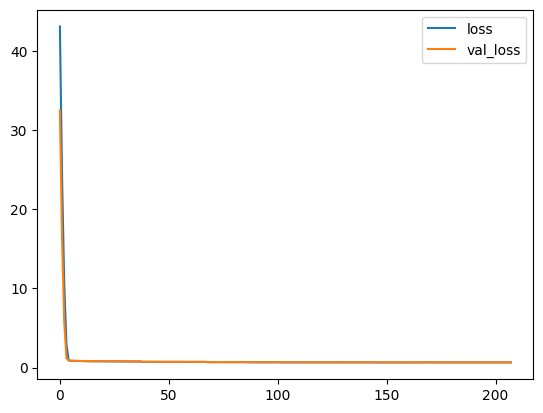

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

### Model Accuracy

The training and validation accuracy both increased rapidly during the first few epochs.
After that, training accuracy continued to improve steadily, while validation accuracy stabilized around 0.75.

<Axes: >

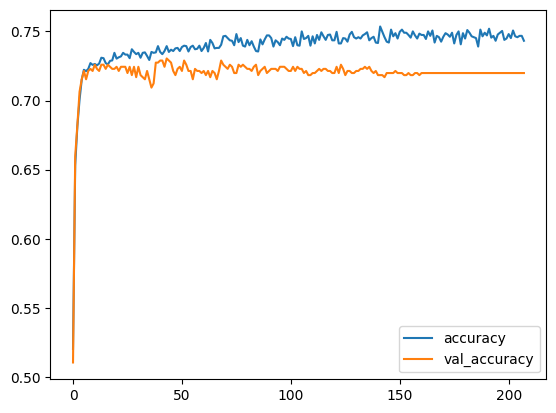

In [ ]:
loss_df[['accuracy', 'val_accuracy']].plot()


### Model Evaluation

The model achieved an accuracy of 0.75 on the test data and 0.76 on the training data, with loss values around 0.62–0.67.
The similar performance across both datasets indicates good generalization and no signs of overfitting.
This evaluation was performed using code adapted from the exercise notebook.

In [ ]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.6669838428497314, 0.7515060305595398]

Train data evaluation:
[0.6219967603683472, 0.7613049149513245]


In [ ]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
categories = ["Dropout", "Enrolled", "Graduate"]

### Confusion Matrix

The confusion matrix shows that the model correctly classified most instances in the two main categories (Dropout and Graduate).
The highest accuracy is seen in the Graduate class, while some misclassifications occur between Dropout and Enrolled.
The Enrolled category shows the highest level of misclassification.
This visualization was created using code adapted from the exercise notebook.

<Axes: >

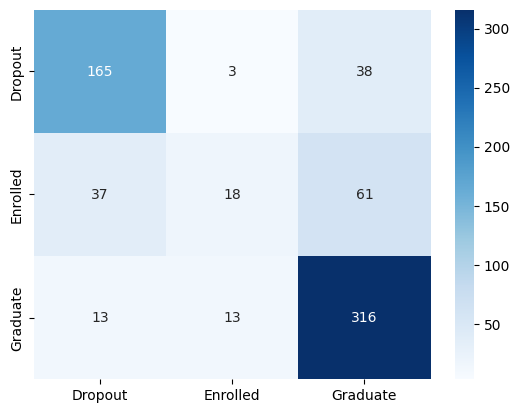

In [ ]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories, cmap="Blues")


### Tuner Results

The tuned model achieved an overall accuracy of 75.2%, slightly below the 75.9% of the non-tuned model.
Performance was strongest for the Graduate class (precision = 0.76, recall = 0.92, F1 = 0.83), while the Enrolled class showed weaker recall (0.16).
Overall, the tuned model delivered balanced results and good generalization, performing nearly as well as the non-tuned version.

In [ ]:
print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

     Dropout       0.77      0.80      0.78       206
    Enrolled       0.53      0.16      0.24       116
    Graduate       0.76      0.92      0.83       342

    accuracy                           0.75       664
   macro avg       0.69      0.63      0.62       664
weighted avg       0.72      0.75      0.72       664


Model overall accuracy: 75.15%


### ROC-AUC Result

The non-tuned model achieved a ROC-AUC score of 0.874, while the tuned model reached 0.871.
Both models show very similar class separation performance, indicating that tuning did not significantly affect the model’s overall discriminative ability.

In [ ]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


0.8714632814799699

### Logistic Regression (Tuner)

The Logistic Regression implementation is based on the official scikit-learn source:
https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_logistic.py
.
GPT was used to refine and simplify the implementation, ensuring adherence to best practices and reproducibility.

In [ ]:
y_train, y_test = map(lambda y: np.argmax(y, axis=1) if y.ndim > 1 else y, [y_train, y_test])

scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)


In [ ]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

test_pred = log_reg.predict(X_test)
test_probs = log_reg.predict_proba(X_test)

In [ ]:
acc = accuracy_score(y_test, test_pred)
roc_auc = roc_auc_score(y_test, test_probs, multi_class='ovr')

Model Overall Accuracy: 0.7440
ROC-AUC: 0.8414

              precision    recall  f1-score   support

     Dropout       0.78      0.76      0.77       206
    Enrolled       0.48      0.21      0.29       116
    Graduate       0.76      0.92      0.83       342

    accuracy                           0.74       664
   macro avg       0.67      0.63      0.63       664
weighted avg       0.72      0.74      0.72       664



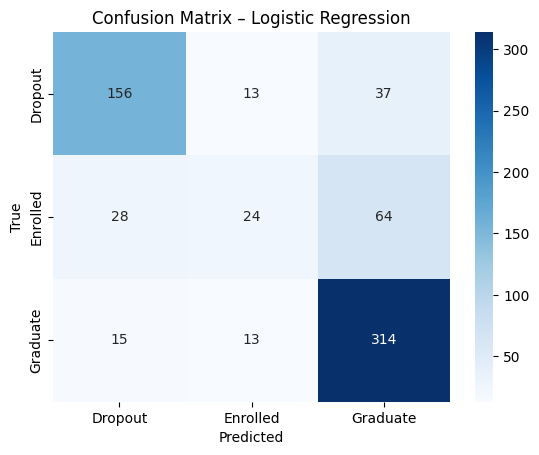

In [ ]:
print(f"Model Overall Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")
print(classification_report(y_test, test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, fmt='g', cmap='Blues',
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

### Model Comparison: Neural Network (Tuner) vs. Logistic Regression (Tuner)

The tuned Neural Network achieved an overall accuracy of 75.2% and a ROC-AUC of 0.87, while the tuned Logistic Regression reached 74.4% accuracy and a ROC-AUC of 0.84.
Both models performed similarly, but the Neural Network showed slightly better class separation and recall for minority classes, reflecting its advantage in capturing non-linear relationships.

### Logistic Regression: Non-Tuned vs. Tuned

The non-tuned Logistic Regression achieved an accuracy of 75.9% and ROC-AUC of 0.86, outperforming the tuned version (74.4%, ROC-AUC 0.84).
Tuning led to a small drop in performance, particularly in recall for the Enrolled class, while Dropout and Graduate predictions remained consistent.
Overall, the non-tuned model generalized slightly better.

In [ ]:
X.columns

Index(['Previous qualification (grade)', 'Admission grade', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Unemployment rate', 'Inflation rate', 'GDP', 'single', 'partnered',
       'prev_partnered', 'admission_general', 'admission_transfer',
       'admission_special/international', 'high_priority', 'studyfield_stem',
       'studyfield_business_social', 'studyfield_arts&comm', 'is_daytime',
       'prevqual_basic', 'prevqual_secondary', 'prevqual_higher',
       'nationality_europe', 'nationality_africa', 'nationality_south_america',
       'nationality_north_america', 'nationality_asia',
       'mother_qualification_basic', 'mother_qualification_secondary',
       'mother_qualification_higher', 'father_qualification_basic',
       'father_qualification_secondary', 'father_qualification_higher',
       'mother_occ_academic', 'mother_occ_technical_admin',
       

### Prediction Tuner Example

To test the model, a single example student profile was created with features such as grades, demographics, and socioeconomic background.
The trained model was used to predict the most likely outcome (Dropout, Enrolled, or Graduate) and the associated class probabilities. 

In [ ]:
tester_row = {
    "Previous qualification (grade)": 150.0,
    "Admission grade": 140.0,
    "Displaced": 0,
    "Educational special needs": 0,
    "Debtor": 0,
    "Tuition fees up to date": 1,
    "Gender": 1,
    "Scholarship holder": 0,
    "Age at enrollment": 20,
    "International": 0,
    "Unemployment rate": 5.2,
    "Inflation rate": 1.2,
    "GDP": 2.3,
    "single": 1,
    "partnered": 0,
    "prev_partnered": 0,
    "admission_general": 1,
    "admission_transfer": 0,
    "admission_special/international": 0,
    "high_priority": 0,
    "studyfield_stem": 1,
    "studyfield_business_social": 0,
    "studyfield_arts&comm": 0,
    "is_daytime": 1,
    "prevqual_basic": 1,
    "prevqual_secondary": 0,
    "prevqual_higher": 0,
    "nationality_europe": 1,
    "nationality_africa": 0,
    "nationality_south_america": 0,
    "nationality_north_america": 0,
    "nationality_asia": 0,
    "mother_qualification_basic": 0,
    "mother_qualification_secondary": 1,
    "mother_qualification_higher": 0,
    "father_qualification_basic": 0,
    "father_qualification_secondary": 0,
    "father_qualification_higher": 1,
    "mother_occ_academic": 0,
    "mother_occ_technical_admin": 1,
    "mother_occ_service_manual": 0,
    "mother_occ_unskilled_other": 0,
    "father_occ_academic": 0,
    "father_occ_technical_admin": 0,
    "father_occ_service_manual": 0,
    "father_occ_unskilled_other": 1,
    "avg_grade": 14.5,
    "success_rate": 0.8,
    "total_enrolled": 11,
    "no_evaluation_total": 0
}

tester_row = pd.DataFrame([tester_row])

result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted outcome: {result_text}\n")
print("Probabilities by class:")
print(categories)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted outcome: Graduate

Probabilities by class:
['Dropout', 'Enrolled', 'Graduate']
[0.1893992  0.31236655 0.4982342 ]


### Student Tuner Outcome GUI

For demonstration purposes, a simple GUI was implemented using Tkinter.
The interface allows users to input student-related features (with default example values provided) and receive a predicted student outcome (Dropout, Enrolled, or Graduate) directly from the trained model.

This GUI code was generated entirely by GPT, as I had not previously worked with Tkinter and wanted a quick and simple way to build an interface for testing predictions.
The correctness was verified by ensuring that all model input features are included in the GUI and that the predicted class output matches the model’s expected format.

In [ ]:
model = load_model("best_model_student2.keras")

default_values = {
    "Previous qualification (grade)": 150.0,
    "Admission grade": 140.0,
    "Displaced": 0,
    "Educational special needs": 0,
    "Debtor": 0,
    "Tuition fees up to date": 1,
    "Gender": 1,
    "Scholarship holder": 0,
    "Age at enrollment": 20,
    "International": 0,
    "Unemployment rate": 5.2,
    "Inflation rate": 1.2,
    "GDP": 2.3,
    "single": 1,
    "partnered": 0,
    "prev_partnered": 0,
    "admission_general": 1,
    "admission_transfer": 0,
    "admission_special/international": 0,
    "high_priority": 0,
    "studyfield_stem": 1,
    "studyfield_business_social": 0,
    "studyfield_arts&comm": 0,
    "is_daytime": 1,
    "prevqual_basic": 1,
    "prevqual_secondary": 0,
    "prevqual_higher": 0,
    "nationality_europe": 1,
    "nationality_africa": 0,
    "nationality_south_america": 0,
    "nationality_north_america": 0,
    "nationality_asia": 0,
    "mother_qualification_basic": 0,
    "mother_qualification_secondary": 1,
    "mother_qualification_higher": 0,
    "father_qualification_basic": 0,
    "father_qualification_secondary": 0,
    "father_qualification_higher": 1,
    "mother_occ_academic": 0,
    "mother_occ_technical_admin": 1,
    "mother_occ_service_manual": 0,
    "mother_occ_unskilled_other": 0,
    "father_occ_academic": 0,
    "father_occ_technical_admin": 0,
    "father_occ_service_manual": 0,
    "father_occ_unskilled_other": 1,
    "avg_grade": 14.5,
    "success_rate": 0.8,
    "total_enrolled": 11,
    "no_evaluation_total": 0
}

def predict():
    try:
        data = {f: float(entries[f].get()) for f in default_values.keys()}
        df = pd.DataFrame([data])
        pred = model.predict(df, verbose=0)[0]
        result_text = f"Predicted outcome probabilities:\nDropout: {pred[0]:.2f}, Enrolled: {pred[1]:.2f}, Graduate: {pred[2]:.2f}"
        result_label.config(text=result_text)
    except Exception as e:
        messagebox.showerror("Error", str(e))

root = tk.Tk()
root.title("Student Success Predictor")
root.geometry("600x700")

main_frame = tk.Frame(root)
main_frame.pack(fill=tk.BOTH, expand=1)

canvas = tk.Canvas(main_frame)
canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=1)

scrollbar = tk.Scrollbar(main_frame, orient=tk.VERTICAL, command=canvas.yview)
scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

canvas.configure(yscrollcommand=scrollbar.set)
canvas.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

frame_inside = tk.Frame(canvas)
canvas.create_window((0, 0), window=frame_inside, anchor="nw")

entries = {}

for f, example in default_values.items():
    row = tk.Frame(frame_inside)
    lab = tk.Label(row, width=28, text=f+": ", anchor="w")
    ent = tk.Entry(row)
    ent.insert(0, str(example))
    hint = tk.Label(row, width=12, text=f"(e.g. {example})", anchor="w", fg="grey")

    row.pack(side=tk.TOP, fill=tk.X, padx=5, pady=2)
    lab.pack(side=tk.LEFT)
    ent.pack(side=tk.LEFT, expand=tk.YES, fill=tk.X)
    hint.pack(side=tk.RIGHT)

    entries[f] = ent

predict_button = tk.Button(frame_inside, text="Predict", command=predict, bg="#4CAF50", fg="white", font=("Helvetica", 10, "bold"))
predict_button.pack(pady=10)

result_label = tk.Label(frame_inside, text="Prediction will appear here", font=("Helvetica", 12), wraplength=500, justify="left")
result_label.pack(pady=10)

def _on_mouse_wheel(event):
    canvas.yview_scroll(int(-1 * (event.delta / 120)), "units")

canvas.bind_all("<MouseWheel>", _on_mouse_wheel)

root.mainloop()
